# K-최근접 이웃 분류 (K-Neighbors Classifier)

## 1. 생선 분류 문제
 분류하기 위해 준비된 생선은 ‘도미’, ‘곤들매기’, ‘농어’, ‘강꼬치고기’, ‘로치’, ‘빙어’, ‘송어’가 있다. 이를 분류하기 위해 어떤 프로그램을 만들까?

> 해당 데이터는 캐글에 공개된 데이터이다.<br>
> https://www.kaggle.com/aungpyaeap/fish-marke<br>
> 혹은 바깥에 있는 fish.csv 데이터를 사용하자. 여기서는 해당 데이터를 사용한다.

 먼저 도미와 빙어를 구분하기로 하자. 머신러닝에서 여러 개의 종류 (<span style="color:green">혹은 클래스(Class)</span>) 중 하나를 구별해내는 문제를 **분류(Classification)**라 부른다. 그 중에서도 2개의 클래스 중 하나를 고르는 문제를 **이진 분류(Binary Classification)**라고 한다.<br>
 → 여기서 class는 파이썬의 클래스와 다르다.

In [14]:
import pandas as pd

domi = pd.read_csv('fish.csv') # 데이터 가져오기

bream_length = domi[domi.Species == 'Bream'].Length2.values
bream_weight = domi[domi.Species == 'Bream'].Weight.values

In [15]:
print("bream_length \n", bream_length)
print("bream_weight \n", bream_weight)

bream_length 
 [25.4 26.3 26.5 29.  29.  29.7 29.7 30.  30.  30.7 31.  31.  31.5 32.
 32.  32.  33.  33.  33.5 33.5 34.  34.  34.5 35.  35.  35.  35.  36.
 36.  37.  38.5 38.5 39.5 41.  41. ]
bream_weight 
 [ 242.  290.  340.  363.  430.  450.  500.  390.  450.  500.  475.  500.
  500.  340.  600.  600.  700.  700.  610.  650.  575.  685.  620.  680.
  700.  725.  720.  714.  850. 1000.  920.  955.  925.  975.  950.]


 여기서 첫 번째 도미의 길이는 25.4cm, 무게는 242.0g과 같은 방식으로 파악할 수 있다. 각 도미의 특징을 길이와 무게로 표현한 것인데, 이 특징을 **특성(feature)**라 칭한다. 데이터를 판단할 수 있는 요소라 보면 이해하기 쉽다.

 데이터를 볼 때는 숫자보다 그래프로 표현하면 이해하기 쉬우며, 앞으로의 작업에 대한 힌트를 얻을 수 있다. 각 도미를 그래프에 점으로 표시할텐데, 이러한 그래프를 **산점도(scatter plot)**라 한다.<br>
→ 파이썬에서 그래프를 그리는 대표적인 패키지는 <span style="color:blue">맷플롯립(matplotlib)</span>이다.

 그래서 코드로 그래프를 표현하면 다음과 같다.

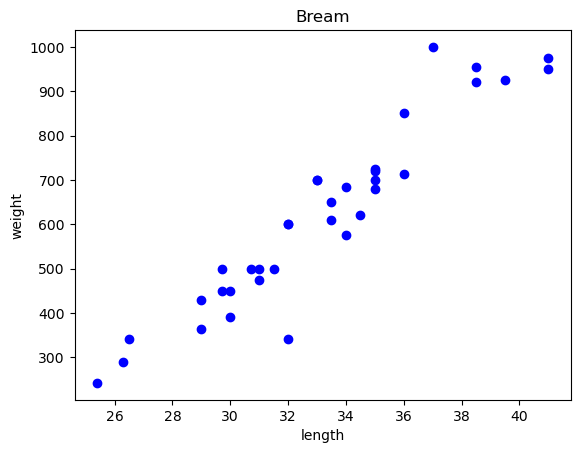

In [16]:
import matplotlib.pyplot as plt

plt.scatter(bream_length, bream_weight, color='blue')
plt.title('Bream')
plt.xlabel('length') # x축은 길이
plt.ylabel('weight') # y축은 무게
plt.show()

 2개의 특성을 사용하였기에 2차원 그래프이다. 산점도를 보면 일직선과 유사한 형태를 보이기에 **선형적(linear)**이라 할 수 있다.

 다음은 빙어 데이터를 가져오자.

In [17]:
smelt_length = domi[domi.Species == 'Smelt'].Length2.values
smelt_weight = domi[domi.Species == 'Smelt'].Weight.values

In [18]:
print("smelt_length \n", smelt_length)
print("smelt_weight \n", smelt_weight)

smelt_length 
 [ 9.8 10.5 10.6 11.  11.2 11.3 11.8 11.8 12.  12.2 12.4 13.  14.3 15. ]
smelt_weight 
 [ 6.7  7.5  7.   9.7  9.8  8.7 10.   9.9  9.8 12.2 13.4 12.2 19.7 19.9]


 해당 데이터를 도미와 빙어 모두 추가하여 산점도를 작성하자.

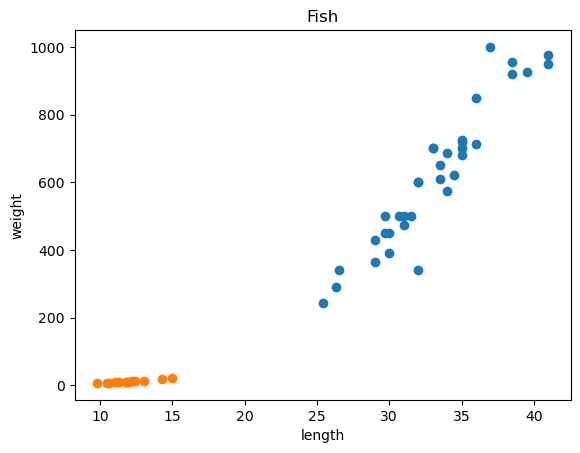

In [19]:
plt.scatter(bream_length, bream_weight) # 다른 데이터를 추가하면 자동으로 다른 색 입력됨
plt.scatter(smelt_length, smelt_weight)
plt.title('Fish')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

 참고로 왼쪽이 빙어, 오른쪽이 도미이다.
 
 2개의 데이터로 산점도가 그려졌다. 우리는 이 데이터를 구분할 수 있는 머신러닝을 만들 것이다.

## 2. 최근접 이웃 (K-Nearest Neighbors)
 우선 머신러닝을 해보기 앞서 도미와 빙어 데이터를 하나로 합쳐줄 것이다.

In [20]:
length = list(bream_length) + list(smelt_length)
weight = list(bream_weight) + list(smelt_weight)

 우리가 사용할 머신러닝 패키지는 사이킷런으로, 사용하기에 앞서 각 특성의 리스트를 세로방향으로 늘어뜨린 2차원 리스트를 만들어야 한다.

 준비해야 될 데이터가 하나 더 있는데, 이는 정답 데이터이다. 어떤 생선이 도미인지, 빙어인지 구별해주기 위한 데이터이다. 이런 데이터가 필요한 이유는 머신러닝이 구분하기 위한 규칙을 찾기 위해선 답도 알려줘야 규칙을 파악할 수 있다. 규칙을 파악한 이후에 다른 데이터를 넣으면 해당 데이터가 도미인지 빙어인지 구분하는 것이다.

In [21]:
fish_data = [[l, w] for l, w in zip(length, weight)] # 2차원 리스트
fish_target = [1]*35 + [0]*14 # 정답 리스트

In [22]:
# 여기서 데이터를 더 쉽게 생성할 수 있는 방법이 있다.
import numpy as np

fish_data = np.column_stack((length, weight))
# np.columns_stack 은 두 리스트를 (n, 2) 형태의 2차원 배열로 생성

fish_target = np.concatenate((np.ones(35), np.zeros(14)))
# np.concatenate 는 두 리스트를 (n, ) 의 형태로 생성

 이제 우리는 완성한 데이터를 통해 k-최근접 이웃 알고리즘을 구현한 클래스 KNeighborsClassifier을 사용할 것이다.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier()

 우리는 KNeighborsClassifier 클래스의 객체를 생성하였다. 이 객체에 fish_data와 fish_target을 전달하여 도미를 찾기 위한 기준을 학습시킨다. 이런 과정을 머신러닝에서 훈련(training)이라 부른다. 사이킷런에서는 fit() 메서드가 이런 역할을 한다.


In [24]:
kn.fit(fish_data, fish_target) # 머신러닝 훈련

kn.score(fish_data, fish_target) # 훈련 평가

1.0

 훈련 후 score() 메서드는 점수를 평가한다. 0과 1 사이의 값을 반환하며, 1은 100점을 의미한다. 만약 절반만 맞춘다면 0.5가 나올 것이다.<br>
 그리고 여기서의 결과값은 1이 나올텐데, 이 값을 **정확도(accuracy)**라 한다. 우리는 새로운 값이 아닌 훈련시킨 값을 그대로 넣었기 때문에 1이 나올 수 있었다.

> 머신러닝 알고리즘을 구현한 프로그램을 <span style="color:blue">모델(model)</span> 이라 한다. 프로그램이 아니더라도 알고리즘을 (수식 등으로) 구체화하여 표현한 것을 모델이라 부른다.

 그럼 k-최근접 이웃 알고리즘은 어떠한 알고리즘일까?
 새로운 데이터에 대한 답을 구할 때, 이 알고리즘은 주위의 다른 데이터를 보고 다수를 차지하는 값을 정답으로 판단한다. 말 그대로 가장 근접한 이웃들을 보고 어떤 사람인지 판단하는 것이다.

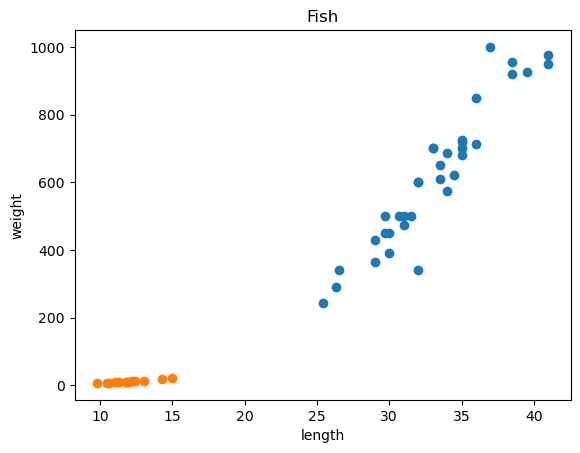

In [25]:
plt.scatter(bream_length, bream_weight)
plt.scatter(smelt_length, smelt_weight)
plt.title('Fish')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

 그럼 위의 그래프에서 파란 도미들 사이에 새로운 데이터가 입력된다면, 어떤 물고기라 생각하겠는가. 당연히 도미라고 판단할 것이다. 주변 데이터는 도미가 가장 많기 때문이다. 우리는 실제로도 그런지 확인해볼 것이다.

In [26]:
kn.predict([[30, 600]])

array([1.])

 predict() 메서드는 새로운 데이터의 정답을 예측한다. 이 메서드도 fit() 과 마찬가지로 2차원 리스트의 형태로 전달해야 한다.<br>
 반환되는 값이 1인 것을 보았을 때, 모델이 추측한 답은 도미라는 것을 알수 있다. <br>
 이렇게 보았을 때 k-최근접 이웃 알고리즘을 위해 준비해야 할 것은 특성의 데이터를 모두 가지고 있으면 된다는 것이다. 다만 이러한 특징 때문에 아주 많은 데이터에는 사용하기 어렵다. 데이터가 크기에 메모리가 많이 필요하며, 직선거리 계산에도 많은 시간이 필요하다.

 KNeighborsClassifier 클래스의 _fit_X 속성에는 우리가 입력한 fish_data를 모두 가지고 있다. 또 _y 속성에 fish_target을 가지고 있다.

In [27]:
print(kn._fit_X)

[[  25.4  242. ]
 [  26.3  290. ]
 [  26.5  340. ]
 [  29.   363. ]
 [  29.   430. ]
 [  29.7  450. ]
 [  29.7  500. ]
 [  30.   390. ]
 [  30.   450. ]
 [  30.7  500. ]
 [  31.   475. ]
 [  31.   500. ]
 [  31.5  500. ]
 [  32.   340. ]
 [  32.   600. ]
 [  32.   600. ]
 [  33.   700. ]
 [  33.   700. ]
 [  33.5  610. ]
 [  33.5  650. ]
 [  34.   575. ]
 [  34.   685. ]
 [  34.5  620. ]
 [  35.   680. ]
 [  35.   700. ]
 [  35.   725. ]
 [  35.   720. ]
 [  36.   714. ]
 [  36.   850. ]
 [  37.  1000. ]
 [  38.5  920. ]
 [  38.5  955. ]
 [  39.5  925. ]
 [  41.   975. ]
 [  41.   950. ]
 [   9.8    6.7]
 [  10.5    7.5]
 [  10.6    7. ]
 [  11.     9.7]
 [  11.2    9.8]
 [  11.3    8.7]
 [  11.8   10. ]
 [  11.8    9.9]
 [  12.     9.8]
 [  12.2   12.2]
 [  12.4   13.4]
 [  13.    12.2]
 [  14.3   19.7]
 [  15.    19.9]]


In [28]:
print(kn._y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


 그렇다면 실제로 k-최근접 이웃 알고리즘에서는 어떤 훈련 과정이 존재하지는 않다는 것을 알 수 있다. 새로운 데이터가 나오면 기존의 입력된 데이터에서 가장 가까운 값을 찾아 정답을 구하기 때문이다.
 다만 여기서 참고하는 데이터의 개수는 우리가 지정하는 것이 가능하다. default 값은 5이며, 기준은 n_neighbors 매개변수로 변경할 수 있다.

In [29]:
kn49 = KNeighborsClassifier(n_neighbors=49) # 참고 데이터를 49개로 한 모델

 문제는 우리는 전체 값이 49개이기 때문에 결국 모든 값을 참고한다는 것을 의미한다. 그렇다면 한 번 정확도를 측정해보자.

In [32]:
kn49.fit(fish_data, fish_target)
kn49.score(fish_data, fish_target)

0.7142857142857143

In [31]:
print(35/49)

0.7142857142857143


 위의 정확도는 어떤 의미일까? 우리가 가진 데이터에서 도미는 35마리, 빙어가 14마리이다. kn49 모델은 도미만 올바르게 맞히기 때문에 35/49의 결과가 정확도와 일치하는 것을 확인할 수 있다.

 때문에 참고 데이터를 무작정 늘린다고 좋은 것이 아님을 알 수 있다.

## 3. 훈련 세트와 테스트 세트
 머신러닝에서는 크게 두 가지로 분류할 수 있다. <span style="color:blue">지도 학습(Superviesd Learning)</span>과 <span style="color:blue">비지도 학습(Unsupervised Learning)</span>이다.
 이 때 우리가 앞서 사용한 지도 학습은 훈련하기 위해 데이터와 정답이 필요하다. 우리는 데이터와 정답을 입력(input)과 타깃(target)이라 하며, 이 둘을 합쳐 훈련 데이터(Training data)라고 부른다. 또한 앞서 언급 했듯이 입력으로 사용된 길이와 무게를 특성(feature)이라 한다.
 다음 그림으로 보면 이해하기 쉬울 것이다.

<img src='img/1/training data.png' width='500'/> 

 지도 학습은 답지(타겟)를 통해 답을 맞추는 방법을 학습한다. 반면 비지도 학습은 답지가 없기에 입력 데이터를 파악하거나 변형(분류 등)를 취한다.
 K-최근접 이웃 알고리즘은 입력 데이터와 타겟(정답)을 사용하였기에 지도 학습 알고리즘이다
 >머신러닝 알고리즘은 지도, 비지도 학습 외에 강화 학습(Reinforcement Learning)을 또 다른 종류로 크게 분류한다..

 문제는 위에서 같은 데이터로 검증 점수를 확인할 때는 당연히 1이 나올 것이다. 미리 알려준 문제와 동일한 문제가 시험에 제출되기 때문이다. 그렇기에 우리는 연습 문제와 시험 문제를 달리 해야 한다.
 그래서 사용하는 방법이 바로 평가에 사용되는 **테스트 세트(test set)**와 훈련에 사용되는 **훈련 세트(training set)**를 분류한다.

 우리는 위에서 특성 fish_data와  타겟 fish_target의 데이터를 만들어놓았다. 이 때 각각 하나의 생선 데이터를 **샘플(sample)**이라 부른다. 우리의 전체 데이터는 49개의 샘플이 있는 것이다. 사용하는 특성은 길이와 무게 2개이며, 이 데이터의 처음 35개를 훈련 세트, 나머지 14개를 테스트 세트로 사용할 것이다.

In [33]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier()

train_input = fish_data[:35]
train_target = fish_target[:35]
test_input = fish_data[35:]
test_target = fish_target[35:]

In [34]:
# 훈련 후 테스트
kn.fit(train_input, train_target)
kn.score(test_input, test_target)

0.0

 그러면 위와 같이 점수가 0이 나오게 되는데 무엇이 문제일까?
 바로 데이터가 섞이지 않았다는 것이 문제이다. 뒤의 14개의 빙어 데이터가 모두 테스트에 들어가 있으니, 도미만 들어간 훈련 데이터에서 빙어를 맞출 수 없는 것이 당연하다. 이렇게 데이터가 한쪽으로 쏠린 경우 **샘플링 편향(sampling bias)**라고 한다. 우리는 빙어와 도미가 섞어서 학습을 진행 해야 할 것이다.

 먼저 numpy를 이용하여 우리가 직접 데이터를 섞어볼 것이다.

In [35]:
import numpy as np

input_arr = np.array(fish_data)
target_arr = np.array(fish_target)

np.random.seed(42) # seed를 지정하여 동일한 결과가 나오도록 섞는다
index = np.arange(49) # 0 ~ n-1 까지 1씩 증가하는 배열을 생성
np.random.shuffle(index)

# 배열 인덱싱(array indexing) 을 사용하여 index 순서대로 나열
train_input = input_arr[index[:35]]
train_target = target_arr[index[:35]]
test_input = input_arr[index[35:]]
test_target = target_arr[index[35:]]

 위와 같이 실행하면 데이터를 섞을 수 있으며, 잘 섞였는지 아래의 산점도를 이용하여 참고할 수 있다.

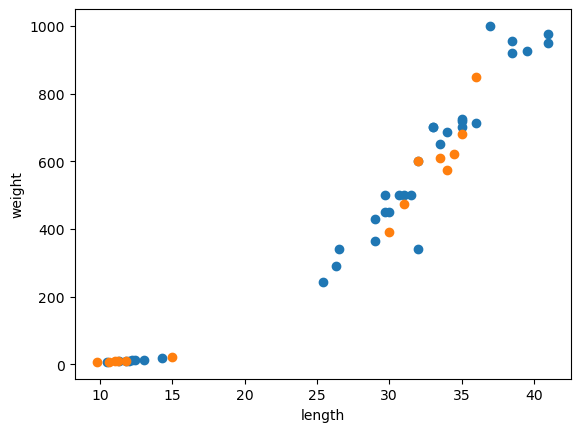

In [36]:
import matplotlib.pyplot as plt

# 2차원 배열에서 행과 열 인덱스를 콤마(,)로 나누어 지정할 수 있다.
plt.scatter(train_input[:, 0], train_input[:, 1])
plt.scatter(test_input[:, 0], test_input[:, 1])
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

In [37]:
# 위의 데이터를 학습해보자.
kn.fit(train_input, train_target)
kn.score(test_input, test_target)

1.0

In [38]:
kn.predict(test_input)

array([0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.])

In [39]:
test_target

array([0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.])

 테스트 세트의 예측 결과가 타겟과 일치하는 것을 확인할 수 있다. 이로써 올바른 평가가 이루어짐을 알 수 있다.

 우린 이 과정을 사이킷런을 이용하여 훨씬 단축시킬 수 있다. 사이킷런의 train_test_split() 이라는 함수가 알아서 훈련 세트와 테스트 세트를 섞어서 나누어줄 것이다.

In [40]:
from sklearn.model_selection import train_test_split

i_train, i_test, t_train, t_test = train_test_split(fish_data, fish_target, test_size=0.25, random_state=42)

 test_size는 훈련 세트와 테스트 세트를 섞는 비율을 말한다. default 값은 0.25로 전체 샘플 중 25%를 테스트 세트로 선별할 것이다. random.seed() 와 같이 동일한 결과를 위하여 42로 고정한다.
 테스트 타겟 값을 통해 잘 섞였는지 확인해보자.

In [41]:
t_test

array([1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

 13개의 샘플 중 10개가 도미(1)고, 3개가 빙어(0)이다. 원래 도미와 빙어의 비율은 35마리와 14마리이므로 2.5:1 이지만 테스트 샘플은 3.3:1 로 샘플링 편향이 조금 존재하다는 것을 알 수 있다.<br>
 이렇게 무작위로 섞었을 때 편향이 나타날 수 있다. 특히 일부 클래스의 개수가 적을 때 나타난다. 이럴 때 stratify 매개변수에 타겟 데이터를 전달하면 클래스 비율에 맞게 데이터를 나눠준다.

In [42]:
i_train, i_test, t_train, t_test = train_test_split(
		fish_data, fish_target, test_size=0.25, stratify=fish_target, random_state=42)
t_test

array([0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.])

 결과를 보면 2.25:1 로 이전보다 조금 더 비슷한 비율이 되었음을 확인할 수 있다.

## 4. 스케일링 (데이터 전처리 Data Preprocessing)
 그럼 이 데이터를 이용하여 K-최근접 이웃을 훈련해보자.

In [43]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier()
kn.fit(i_train, t_train)
kn.score(i_test, t_test)

1.0

 위의 결과는 1.0으로 올바르게 분류하였다. 그렇다면 다음 도미 샘플을 넣으면 올바르게 분류할 것이라 예측된다.

In [44]:
kn.predict([[25, 150]])

array([0.])

 그러나 도미가 아니라 빙어로 예측한다. 무슨 문제인지 파악하기 위해선 산점도로 확인해보는 것이 가장 쉽다.

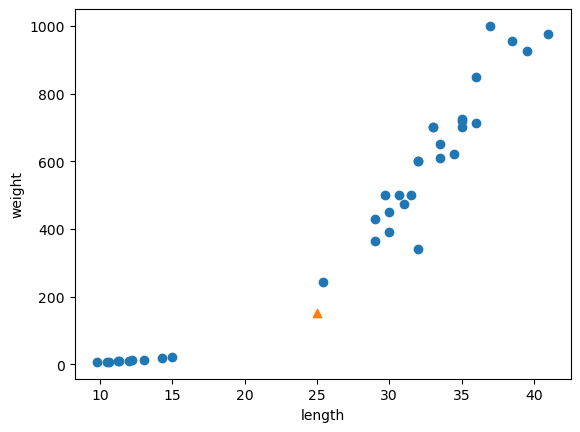

In [45]:
plt.scatter(i_train[:,0], i_train[:,1])
plt.scatter(25, 150, marker='^') # '^' : 삼각형
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

 새로운 샘플을 삼각형으로 지정하여 따로 표시했다. 그래프로 보기엔 좌측 하단의 빙어보다는 도미에 훨씬 가까워 보인다. K-최근접 이웃은 주변의 샘플 중 다수인 클래스를 예측으로 사용한다. 그렇다면 이 샘플의 이웃을 확인해볼 필요가 있다. KNeighborsClassifier 클래스는 가장 가까운 이웃을 찾아주는 kneighbors() 메서드를 제공한다.

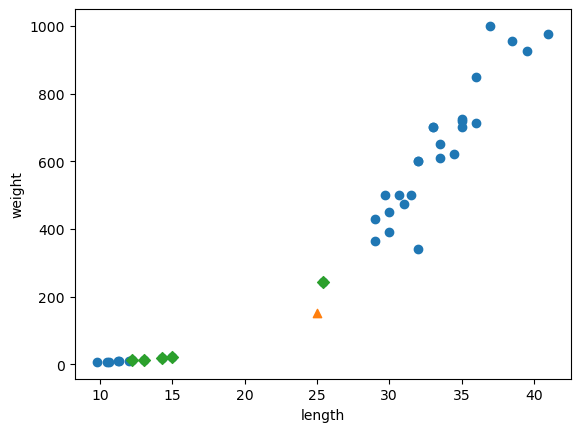

In [46]:
distances, indexes = kn.kneighbors([[25, 150]])

plt.scatter(i_train[:, 0], i_train[:, 1])
plt.scatter(25, 150, marker='^')
plt.scatter(i_train[indexes, 0], i_train[indexes, 1], marker='D') # 'D' : 마름모
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

 우리가 본 것과 달리 이웃으로 도미는 하나밖에 선택되지 않았다. 그렇다면 kneighbors() 메서드에서 반환한 distances는 이웃 샘플까지의 거리가 담겨있다. 이 데이터를 확인해보자.

In [47]:
distances

array([[ 92.00086956, 130.48375378, 130.73859415, 138.32150953,
        138.39320793]])

<img src='img/1/distances.png' width='500'/> 

 거리를 그림과 비교해봤을 때 이질감을 알아챌 수 있다. 분명 거리상으로 몇 배나 돼 보이지만 수치상으로는 큰 차이가 없다.
 이유는 X축과 Y축의 단위 차이에서 알아챌 수 있다. X축은 -~40 인 것에 비,해 Y축은 -~1000 까지의 범위를 표시한다. 이러니 육안으로는 짧아 보여도 수치로 봤을 때 훨씬 멀 수밖에 없을 것이다. 좀 더 알아보기 쉽게 그래프의 범위를 달리해보면 다음과 같다.

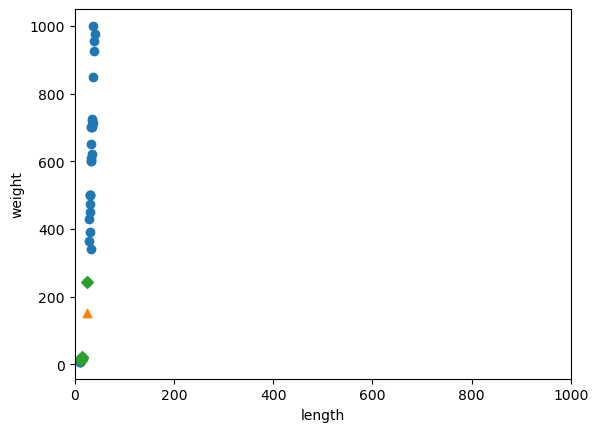

In [48]:
plt.scatter(i_train[:, 0], i_train[:, 1])
plt.scatter(25, 150, marker='^')
plt.scatter(i_train[indexes, 0], i_train[indexes, 1], marker='D')
plt.xlim((0, 1000))
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

거리의 체감을 훨씬 느낄 수 있다. 이렇게 비교해보면 두 특성 (길이와 무게) 의 값이 놓인 범위가 다른 경우가 대부분이다. 이를 두 특성의 <span style="color:blue">**스케일(scale)**</span>이 다르다고 표현한다. 쉬운 예시로 방의 넓이를 잴 때 세로는 cm로, 가로는 inch로 잰 상황이나 다름 없는 것이다.
 특히나 알고리즘이 거리 기반일 때 이런 현상이 많이 나타난다. 그렇다면 특성값을 일정한 기준으로 맞춰 주어야 하는데, 이런 작업을 **데이터 전처리(Data Processing)**이라고 한다. 가장 널리 사용하는 전처리 방법 중 하나가 **표준점수(standard score)**인데 각 특성값이 평균에서 표준편차의 몇 배만큼 떨어져 있는 지를 확인한다. 

 즉 평균을 빼고 표준편차를 나누어주면 된다. 간단하게 코드로 표준점수를 구해보자

In [49]:
mean = np.mean(i_train, axis=0) # 평균
std = np.std(i_train, axis=0) # 표준편차
train_scaled = (i_train - mean) / std

 위의 코드에서 i_train 이 (36, 2)의 형태임에도 넘파이는 모든 행과 열의 값을 각각 계산하여 대입해준다. 이런 넘파이의 기능을 <span style="color:blue">**브로드캐스팅(Broadcasting)**</span>이라고 부른다.

 그러면 전처리한 값들과 샘플을 산점도에 표시해보자.

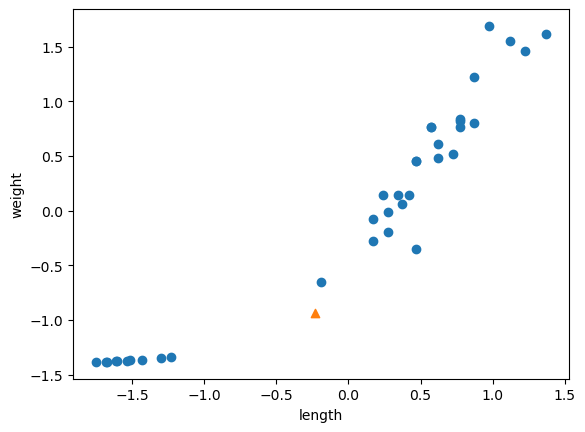

In [51]:
new = ([25, 150] - mean) / std
plt.scatter(train_scaled[:, 0], train_scaled[:, 1])
plt.scatter(new[0], new[1], marker='^')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

 전처리하기 전의 산점도와  x축과 y축의 범위 외에는 달라진 게 없어 보인다. 그렇다면 이 데이터셋으로 훈련하여 예측해보자.

In [52]:
kn.fit(train_scaled, t_train)
test_scaled = (i_test - mean) / std
kn.score(test_scaled, t_test)

1.0

In [53]:
kn.predict([new])

array([1.])

 드디어 샘플을 도미(1)로 예측했음을 확인할 수 있다. 그렇다면 어떤 이웃을 참고하였는지 한 번 더 산점도로 확인해보자.

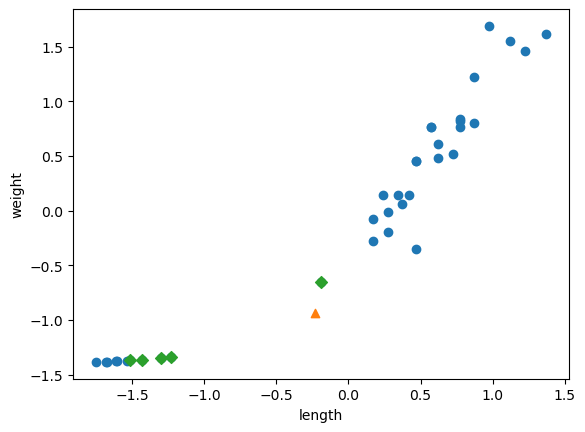

In [55]:
distances, indexs = kn.kneighbors([new])
plt.scatter(train_scaled[:, 0], train_scaled[:, 1])
plt.scatter(new[0], new[1], marker='^')
plt.scatter(train_scaled[indexes, 0], train_scaled[indexes, 1], marker='D')
plt.xlabel('length')
plt.ylabel('weight')
plt.show()

 이제 이전과 달리 육안으로 가까워 보이는 이웃들을 참고했다. 이처럼 데이터 전처리가 필요한 상황이 있을 수 있다.